# Parallel programming in GPU with Numba

This notebook is based on a series by [Carlos Costa](https://medium.com/@cdacostaf) split in 4 parts:

- [Part 1](https://towardsdatascience.com/cuda-by-numba-examples-1-4-e0d06651612f) or in [Google Colab](https://colab.research.google.com/drive/1h0Savk8HSIgraT61burXQwbEUDMz4HT6?usp=sharing)
- [Part 2](https://towardsdatascience.com/cuda-by-numba-examples-215c0d285088) or in [Google Colab](https://colab.research.google.com/drive/1GkGLDexnYUnl2ilmwNxAlWAH6Eo5ZK2f?usp=sharing)
- [Part 3](https://towardsdatascience.com/cuda-by-numba-examples-7652412af1ee) or in [Google Colab](https://colab.research.google.com/drive/1iRUQUiHUVdl3jlKzKucxQHQdDPElPb3M?usp=sharing)
- [Part 4](https://towardsdatascience.com/cuda-by-numba-examples-c583474124b0) or in [Google Colab](https://colab.research.google.com/drive/1Eq1Xyuq8hJ440ma_9OBrEVdGm3bIyigt?usp=sharing)


Alternative implementations can be found in:

- [CuPy](https://cupy.dev/): provides functionalities similar to Numba and also some low level features.
- [PyCUDA](https://documen.tician.de/pycuda/): goes deeper in the lower level of direct CUDA API access.
- [cuda-python](https://nvidia.github.io/cuda-python/overview.html): official Nvidia Python API to CUDA, still giving its first steps.

The CUDA programming model is provided [here](https://developer.nvidia.com/blog/cuda-refresher-cuda-programming-model/).

In [1]:
from time import perf_counter_ns
from cuda import cuda as cc
from numba import cuda as nc
from skimage import data
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import numba

%matplotlib inline

In [2]:
print(np.__version__)
print(numba.__version__)
nc.detect()

1.22.4
0.56.0
Found 1 CUDA devices
id 0         b'Quadro M2200'                 [SUPPORTED (DEPRECATED)]
                      Compute Capability: 5.2
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f7796073-49a0-29ce-25a0-5cd1d0ec228a
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [3]:
warnings.simplefilter("ignore", numba.NumbaPerformanceWarning)

## Introduction to CUDA through Numba

### Basics of *Host* and *Device* allocation

In [4]:
@nc.jit
def add_scalars(a, b, c):
    c[0] = a + b

In [5]:
dev_c = nc.device_array((1,), np.float32)

blocks = 1
threads = 1
add_scalars[blocks, threads](2.0, 7.0, dev_c)

c = dev_c.copy_to_host()
print(f"2.0 + 7.0 = {c[0]}")

2.0 + 7.0 = 9.0


### Computing an array in the *Device*

In [6]:
@nc.jit
def add_array(a, b, c):
    i = nc.threadIdx.x + nc.blockDim.x * nc.blockIdx.x
    
    if i < a.size:
        c[i] = a[i] + b[i]

In [7]:
N = 18
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

In [8]:
c = a + b
print(c)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.]


In [9]:
dev_a = nc.to_device(a)
dev_b = nc.to_device(b)
dev_c = nc.device_array_like(a)

In [10]:
threads = 8
blocks = 4
add_array[blocks, threads](dev_a, dev_b, dev_c)

In [11]:
host_c = dev_c.copy_to_host()
np.allclose(c, host_c)

True

### Improvement of previous code

In [12]:
@nc.jit
def add_array_with_grid(a, b, c):
    i = nc.grid(1)
    if i < a.size:
        c[i] = a[i] + b[i]

In [13]:
threads = 8
blocks = 4
add_array_with_grid[blocks, threads](dev_a, dev_b, dev_c)

### Generalizing for any array size

More on this can be found in [Nsight Compute](https://developer.nvidia.com/nsight-compute).

note that blocks == ceil(N / threads)

ensures that blocks * threads >= N

In [14]:
N = 200_000_000
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

dev_a = nc.to_device(a)
dev_b = nc.to_device(b)
dev_c = nc.device_array_like(a)

threads = 256
blocks = (N + threads - 1) // threads

add_array[blocks, threads](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
np.allclose(a + b, c)

True

### Side note on GPU attributes

Attributes of a GPU can be accessed with [cuda.cuda.cuDeviceGetAttribute](https://nvidia.github.io/cuda-python/module/cuda.html#cuda.cuda.cuDeviceGetAttribute), where the `cuda` module refers to `cuda-python` package.

In [15]:
# Initialize CUDA Driver API
(_,) = cc.cuInit(0)

In [16]:
# Get attributes
_, DEVICE_NAME = cc.cuDeviceGetName(128, 0)
DEVICE_NAME.decode("ascii").replace("\x00", "")

'Quadro M2200                                                                                                                   '

In [17]:
def get_cudevice_attr(name, dev=cc.CUdevice()):
    attr = getattr(cc.CUdevice_attribute, name)
    return cc.cuDeviceGetAttribute(attr, dev=dev)[1]

In [18]:
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK"))

1024


In [19]:
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X"))
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_Y"))
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_Z"))

1024
1024
64


In [20]:
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X"))
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_Y"))
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_Z"))

2147483647
65535
65535


In [21]:
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT"))

8


### Grid-stride *GS* loops approach

More on this can be found [here](https://developer.nvidia.com/blog/cuda-pro-tip-write-flexible-kernels-grid-stride-loops/).

In [22]:
@nc.jit
def add_array_gs(a, b, c):
    i_start = nc.grid(1)
    threads_per_grid = nc.blockDim.x * nc.gridDim.x
    for i in range(i_start, a.size, threads_per_grid):
        c[i] = a[i] + b[i]

Use 32 * multiple of streaming multiprocessors

32 * 80 * 256 < 1_000_000 so one thread will process more than one array element

In [23]:
N = 200_000_000
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

dev_a = nc.to_device(a)
dev_b = nc.to_device(b)
dev_c = nc.device_array_like(a)

threads = 256
blocks = 32 * 80
add_array_gs[blocks, threads](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
np.allclose(a + b, c)

True

### Performance of CUDA kernels

More about this [here](https://developer.nvidia.com/blog/how-implement-performance-metrics-cuda-cc/).

In [24]:
@nc.jit
def add_array_linear(a, b, c):
    i = nc.grid(1)
    if i < a.size:
        c[i] = a[i] + b[i]


@nc.jit
def add_array_gs(a, b, c):
    i_start = nc.grid(1)
    threads_per_grid = nc.blockDim.x * nc.gridDim.x
    for i in range(i_start, a.size, threads_per_grid):
        c[i] = a[i] + b[i]

In [25]:
N = 100_000_000
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

dev_a = nc.to_device(a)
dev_b = nc.to_device(b)
dev_c = nc.device_array_like(a)

In [26]:
threads_linear = 256
blocks_linear = (N + threads_linear - 1) // threads_linear
add_array_linear[blocks_linear, threads_linear](dev_a, dev_b, dev_c)
nc.synchronize()

threads_gs = 256
blocks_gs = 32 * 80
add_array_gs[blocks_gs, threads_gs](dev_a, dev_b, dev_c)
nc.synchronize()

In [27]:
def performance(f, a, b, c):
    timing = np.empty(101)

    for i in range(timing.size):
        tic = perf_counter_ns()
        f(a, b, c)
        nc.synchronize()
        toc = perf_counter_ns()
        timing[i] = toc - tic

    timing *= 1e-6
    gflops = 1e-9 * a.size * 1e3 / timing.mean()

    print(f"Elapsed: {timing.mean():.1f} ± {timing.std():.1f} ms")
    print(f"GFLOP/s: {gflops:.2f}")

In [28]:
kernel = add_array_linear[blocks_linear, threads_linear]
performance(kernel, dev_a, dev_b, dev_c)

Elapsed: 16.9 ± 0.3 ms
GFLOP/s: 5.91


In [29]:
kernel = add_array_gs[blocks_gs, threads_gs]
performance(kernel, dev_a, dev_b, dev_c)

Elapsed: 18.2 ± 0.3 ms
GFLOP/s: 5.48


### Going towards 2D processing

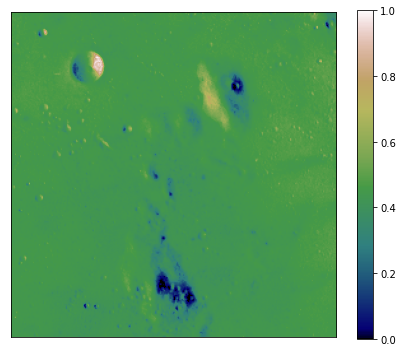

In [30]:
moon = data.moon().astype(np.float32) / 255.

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(moon, cmap="gist_earth")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.colorbar(im)
fig.tight_layout()

In [31]:
@nc.jit
def adjust_log(inp, gain, out):
    # The first index is the fastest dimension
    ix, iy = nc.grid(2)

    #  threads per grid dimension
    threads_per_grid_x, threads_per_grid_y = nc.gridsize(2)
    
    # The last index is the fastest dimension
    n0, n1 = inp.shape

    # Stride each dimension independently
    for i0 in range(iy, n0, threads_per_grid_y):
        for i1 in range(ix, n1, threads_per_grid_x):
            out[i0, i1] = gain * math.log2(1.0 + inp[i0, i1])

In [32]:
threads_per_block_2d = (16, 16)
blocks_per_grid_2d = (64, 64)

moon_gpu = nc.to_device(moon)
moon_corr_gpu = nc.device_array_like(moon_gpu)

adjust_log[blocks_per_grid_2d, threads_per_block_2d](moon_gpu, 1.0, moon_corr_gpu)
moon_corr = moon_corr_gpu.copy_to_host()

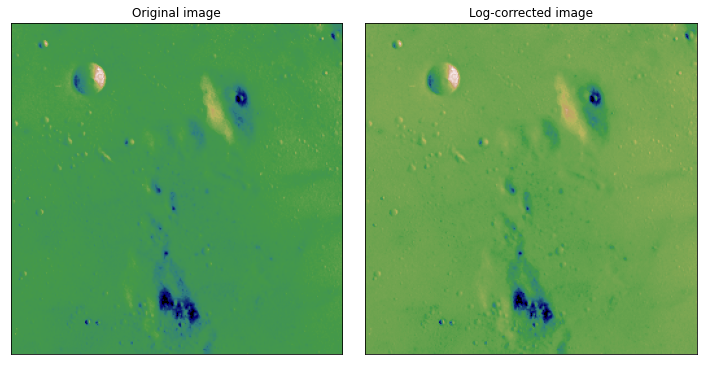

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(moon, cmap="gist_earth")
ax2.imshow(moon_corr, cmap="gist_earth")
ax1.set(title="Original image")
ax2.set(title="Log-corrected image")

for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.tight_layout()

## Thread cooperation

## Streams and events

## Atomic instructions and *mutex*